In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/TCC/

/content/drive/MyDrive/TCC


In [ ]:
!apt install tesseract-ocr
!apt install libenchant1c2a

In [ ]:
!pip install pytesseract
!pip install ISR
!pip install opencv-python
!pip install 'h5py==2.10.0' --force-reinstall
!pip install pyenchant

In [ ]:
import numpy as np
import pandas as pd
import cv2
import pytesseract
import PIL
import re
import enchant

from PIL import Image
from ISR.models import RDN

### Pipeline

In [ ]:
def unwarp(img, src, dst):
    h, w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)
    return warped, M

def findDestinationPoints(src, shape):
    w_list = [
        abs(src[0][0] - src[1][0]),
        abs(src[2][0] - src[3][0])
    ]
    h_list = [
        abs(src[0][1] - src[2][1]),
        abs(src[1][1] - src[3][1])
    ]
    max_w = max(w_list) # maior lado horizontal do recibo
    max_h = max(h_list) # maior lado vertical do recibo

    h, w = shape[0], shape[1]
    inc_w = (w - max_w) / 2
    inc_h = (h - max_h) / 2

    return np.float32([(inc_w, inc_h),
                    (inc_w + max_w, inc_h),
                    (inc_w, inc_h + max_h),
                    (inc_w + max_w, inc_h + max_h)])

def homography(image, points):
    src = np.array(points, dtype="float32")
    dst = findDestinationPoints(src, image.shape)   
    warped_img, M = unwarp(image, src, dst)
    return warped_img, dst

In [ ]:
def medianBlur(image, filter_size):
    return cv2.medianBlur(image, filter_size)

def sharp(image):
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

def binarizeAdaptive(image, T, C, show=False):
    binarized = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, T, C)
    return binarized

def ISR(image):
    lr_img = np.array(image)
    rdn = RDN(weights='psnr-small')
    sr_img = rdn.predict(lr_img)
    return sr_img

In [ ]:
def pipeline(img):
    print("Homografia: ")
    display(Image.fromarray(img.astype('uint8')))
    image = ISR(img)
    print("ISR: ")
    display(Image.fromarray(image.astype('uint8')))
    image = medianBlur(image, filter_size=3)
    print("Filtro da mediana: ")
    display(Image.fromarray(image.astype('uint8')))
    image = cv2.dilate(image, np.zeros((5, 5), 'uint8'), iterations=4)
    print("Dilatação: ")
    display(Image.fromarray(image.astype('uint8')))
    image = sharp(image)
    print("Ajuste de nitidez: ")
    display(Image.fromarray(image.astype('uint8')))
    image = binarizeAdaptive(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 19, 25)
    return image

In [ ]:
def addBorders(image, points):
    cv2.line(image, tuple(points[0].astype(int)), tuple(points[1].astype(int)), color=(0, 0, 0), thickness=3)
    cv2.line(image, tuple(points[1].astype(int)), tuple(points[3].astype(int)), color=(0, 0, 0), thickness=3)
    cv2.line(image, tuple(points[2].astype(int)), tuple(points[3].astype(int)), color=(0, 0, 0), thickness=3)
    cv2.line(image, tuple(points[2].astype(int)), tuple(points[0].astype(int)), color=(0, 0, 0), thickness=3)

### OCR

In [ ]:
def accuracyByLevenshteinDistance(textOCR, label):
    text = re.sub(r"[\n\t\s]*", "", textOCR)
    labelText = re.sub(r"[\n\t\s]*", "", label)
    levDistance = enchant.utils.levenshtein(text, labelText)
    accuracy = (len(labelText)-levDistance) / len(labelText)
    return accuracy

In [ ]:
def ocr(image, options):
    return pytesseract.image_to_string(image, config=options)

### Processamento

In [ ]:
def readCSV():
    df = pd.read_csv("Dataset/homography.csv", sep=";")
    return df

In [ ]:
points = [[],[],[],[]]

df = readCSV()
image = df['Image'].tolist()
for i, column in enumerate(df.columns):
    if column == 'Image':
        continue
    for point in df[column]:
        t_point = (int(point.split(',')[0]), int(point.split(',')[1]))
        points[i-1].append(t_point)

In [ ]:
ignore = [1025,1034,1041,1045,1063,1109,1137,1151,1158,1169,1194,1192]
# 1151 gerou falta de RAM

Número de imagens:  199
Imagem original: 


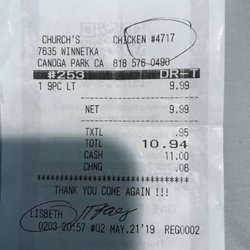

Homografia: 


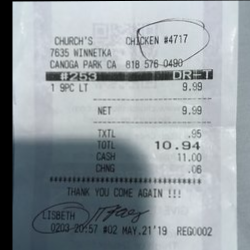

ISR: 


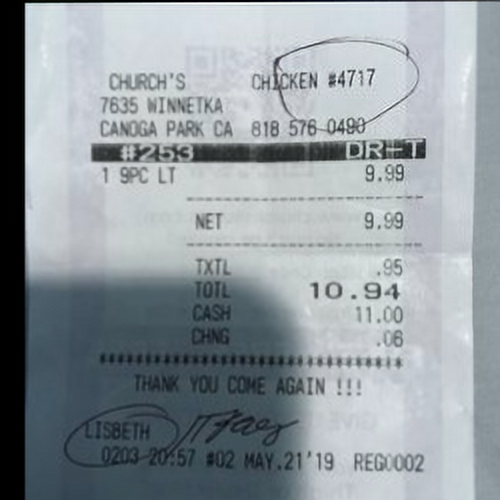

Filtro da mediana: 


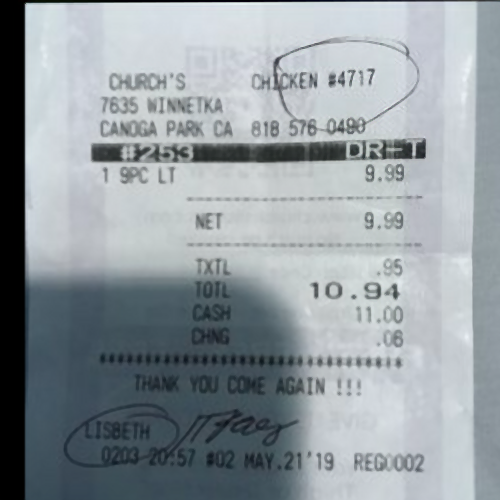

Dilatação: 


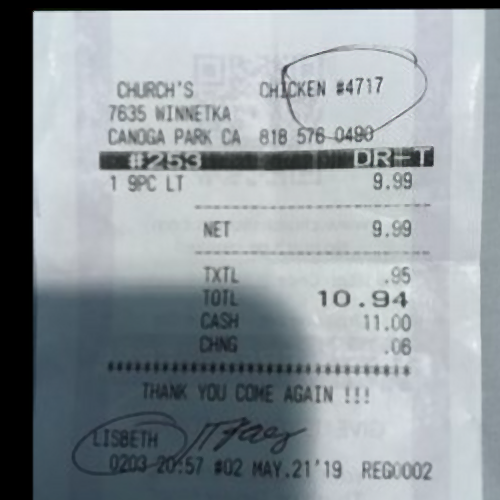

Ajuste de nitidez: 


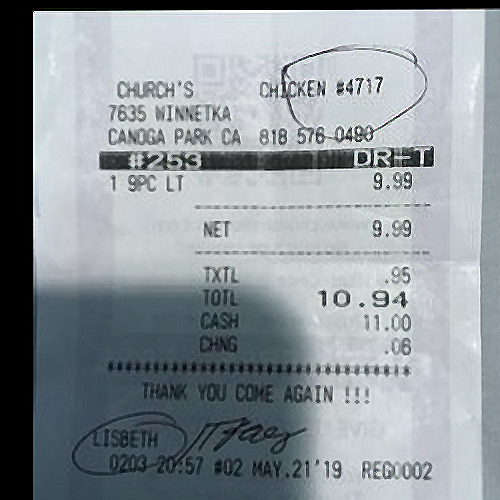

Binarização e fim: 


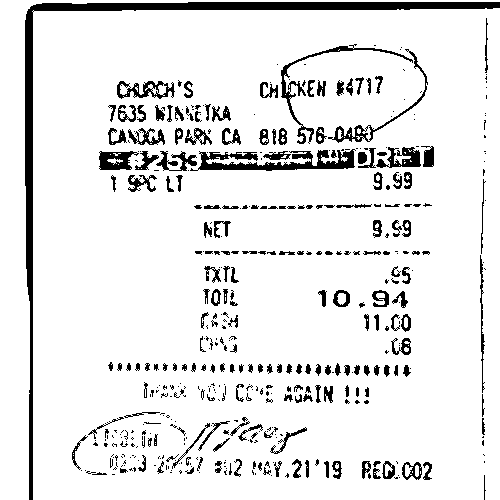

In [ ]:
# colocar as imagens aqui
image_list = []
accuracy = []

manual = True
apply_pipeline = True

range_list = [44]#[2,26,95]

print('Número de imagens: ', len(image))

for i in range_list:
    if image[i] in ignore:
        continue
    image_list.append(image[i])
    name = str(image[i]) + '-receipt'
    img = cv2.imread('Dataset/' + name + '.jpg')
    print("Imagem original: ")
    display(Image.fromarray(img.astype('uint8')))
    if apply_pipeline:
        if manual:
            img_points = []
            for j in range(4):
                x,y = points[j][i][0], points[j][i][1]
                img_points.append((x,y))
            # src = np.array(img_points, dtype="float32")
            # addBorders(img, points=src)
            warped_image, dst_points = homography(img, points=img_points)
            # image_processed = warped_image.copy()
            image_processed = pipeline(warped_image)
        else:
            image_processed = pipeline(img)
        print("Binarização e fim: ")
        display(Image.fromarray(image_processed.astype('uint8')))
        text = ocr(image_processed, "--psm 4 -c tessedit_write_images=0")
    else:
        text = ocr(img, "--psm 4 -c tessedit_write_images=0")
    label = open('Dataset/Labels/' + name + '.txt', "r")
    acc = accuracyByLevenshteinDistance(text, label.read())
    accuracy.append(acc)
    # print(image[i])

In [ ]:
print(accuracy)

[0.32335329341317365]


In [ ]:
acc_df = pd.DataFrame({'Image': image_list, 'Accuracy': accuracy})
acc_df.to_csv('Dataset/Accuracy/accuracy-6.csv', index=False, sep=';')

In [ ]:
image_list = [1167]

accuracy = []

i = 166
name = str(image[i]) + '-receipt'
img = cv2.imread('Dataset/' + name + '.jpg')
img_points = []
for j in range(4):
    x,y = points[j][i][0], points[j][i][1]
    img_points.append((x,y))
warped_image = homography(img, points=img_points)
image_processed = pipeline(img)
display(Image.fromarray(image_processed.astype('uint8')))
text = ocr(image_processed, "--psm 4 -c tessedit_write_images=0")

In [ ]:
print(accuracy)

[0.4893048128342246, -0.5103448275862069, 0.3333333333333333]
